First, we'll obtain the single-peak Gaussian signals that we randomly generated. This will be the simplest test case for this RNN method, and we'll build the complexity from here.

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np

In [5]:
# try making Gauss peaks more narrow

In [6]:
# path = 'saved_data/math_functions_single.nc'
path = 'saved_data/math_functions_single_narrow.nc'

# Load .nc file
ds = xr.open_dataset(path)

gaussians = ds["Gaussians"].values
binary = ds["BinaryArr"].values
print(type(binary))
for j in range(binary.shape[0]):
    idx = np.where(binary[j] == 1)[0][0] # because there's only 1 "1" we can use [0][0]
    binary[j][idx - 2] = 1
    binary[j][idx - 1] = 1
    binary[j][idx + 1] = 1
    binary[j][idx + 2] = 1

x = ds["x"].values

<class 'numpy.ndarray'>


In [7]:
binary.shape

(10000, 500)

Visualize some of the randomly generated Gaussian signals with single peaks.

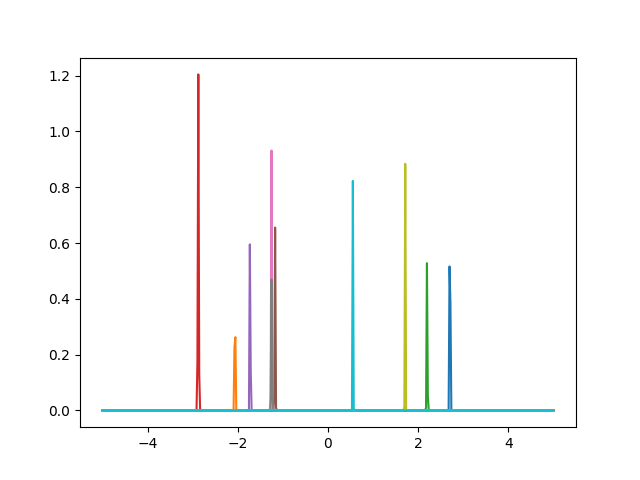

In [8]:
plt.figure()

for i in range(10):
    plt.plot(x, gaussians[i])

# adding noise: Dan says to add it to improve perfromance
# any weight in NN times 0 is 0. ideally what this is learning is a series of weights with behavior you want
# problem with 0 is that it's so sharp that those weights don't behave
# noise level of 0.05 or smth poisson distribution

In [9]:
import torch
import torch.nn as nn

In [10]:
sequence_length = 500 # num of x values
input_size = 2 # 2 because we have (x, intensity) coordinates, which are 2 features

# input shape should be: (batch_size, sequence_length, input_size)
batch_size = 32 # can make batch size = 5?

In [11]:
i = 1 
peak_idx = gaussians[i].argmax()
peak_x = x[peak_idx]

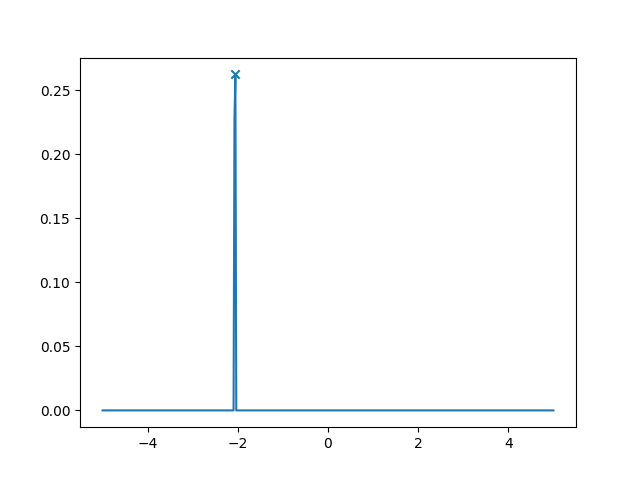

In [12]:
peak_idx
plt.figure()
plt.scatter(peak_x, gaussians[i][peak_idx], marker='x')
plt.plot(x, gaussians[i])

In [13]:
import torch.optim as optim

In [14]:
total_num = gaussians.shape[0]

all_x_arrs = []
for _ in range(total_num):
    all_x_arrs.append(x)

all_xs = np.stack(all_x_arrs, axis=0)
all_xs.shape

(10000, 500)

In [15]:
# data shape: (batch_size, sequence_length, input_size)
# make data tensor
# ()
print(all_xs.shape)
print(gaussians.shape)

(10000, 500)
(10000, 500)


In [16]:
gaussians[0]

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [17]:
from torch.utils.data import DataLoader, TensorDataset

In [18]:
all_data = torch.from_numpy(np.stack((all_xs, gaussians), axis=-1).astype(np.float32)) # shape = (1000, 500, 2)
binary = torch.from_numpy(binary)
print(all_data.shape)
print(binary.shape)

torch.Size([10000, 500, 2])
torch.Size([10000, 500])


In [19]:
from sklearn.model_selection import train_test_split

tv_X, test_X, tv_y, test_y = train_test_split(all_data, binary, test_size=0.2, shuffle=False)
train_X, val_X, train_y, val_y = train_test_split(tv_X, tv_y, test_size = 0.25, shuffle=False)

In [20]:
train_X = train_X.float()
val_X = val_X.float()
test_X = test_X.float()

train_y = train_y.float()
val_y = val_y.float()
test_y = test_y.float()

In [21]:
train_ds = TensorDataset(train_X, train_y)
val_ds = TensorDataset(val_X, val_y)
test_ds = TensorDataset(test_X, test_y)

In [22]:
train_ds.tensors

(tensor([[[-5.0000,  0.0000],
          [-4.9800,  0.0000],
          [-4.9599,  0.0000],
          ...,
          [ 4.9599,  0.0000],
          [ 4.9800,  0.0000],
          [ 5.0000,  0.0000]],
 
         [[-5.0000,  0.0000],
          [-4.9800,  0.0000],
          [-4.9599,  0.0000],
          ...,
          [ 4.9599,  0.0000],
          [ 4.9800,  0.0000],
          [ 5.0000,  0.0000]],
 
         [[-5.0000,  0.0000],
          [-4.9800,  0.0000],
          [-4.9599,  0.0000],
          ...,
          [ 4.9599,  0.0000],
          [ 4.9800,  0.0000],
          [ 5.0000,  0.0000]],
 
         ...,
 
         [[-5.0000,  0.0000],
          [-4.9800,  0.0000],
          [-4.9599,  0.0000],
          ...,
          [ 4.9599,  0.0000],
          [ 4.9800,  0.0000],
          [ 5.0000,  0.0000]],
 
         [[-5.0000,  0.0000],
          [-4.9800,  0.0000],
          [-4.9599,  0.0000],
          ...,
          [ 4.9599,  0.0000],
          [ 4.9800,  0.0000],
          [ 5.0000,  0.0000

In [348]:
# sequence_length = gaussians.shape[1]

# idx_1 = int(total_num*0.6)
# idx_2 = int(total_num*0.8)

# train_x = torch.from_numpy(all_xs[0 : idx_1])
# train_gauss = torch.from_numpy(gaussians[0 : idx_1])

# val_x = torch.from_numpy(all_xs[idx_1 : idx_2])
# val_gauss = torch.from_numpy(gaussians[idx_1 : idx_2])

# test_x = torch.from_numpy(all_xs[idx_2 : ])
# test_gauss = torch.from_numpy(gaussians[idx_2 : ])

In [349]:
# print(train_x.shape)
# print(val_x.shape)
# print(test_x.shape)

# print(train_x.shape)
# print(val_x.shape)
# print(test_x.shape)

In [350]:
# train_x = train_x.float()
# val_x = val_x.float()
# test_x = test_x.float()

In [351]:
# train_gauss = train_gauss.float()
# val_gauss = val_gauss.float()
# test_gauss = test_gauss.float()

In [352]:
# train_ds = TensorDataset(train_x, train_gauss)
# val_ds = TensorDataset(val_x, val_gauss)
# test_ds = TensorDataset(test_x, test_gauss)

In [23]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [24]:
class PeakFinderRNN(nn.Module):
    # maybe should make input size 2? idk ...
    def __init__(self, input_size=input_size, hidden_size=64, num_layers=1, output_size=1):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size) # output_size=1 
    
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        logits = self.fc(rnn_out)  # Predict peak position
        return logits.squeeze(-1)  # shape: (batch,)

In [25]:
model = PeakFinderRNN()
pos_weight = torch.tensor([100.0])  # e.g., ratio of 1/0 samples
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 10
train_loss = []
val_loss = []
for epoch in range(num_epochs):
    model.train()
    
    for x, y in train_loader:
        pred_y = model(x)
        
        loss = criterion(pred_y, y)
        print(pred_y, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        # print(f'train_loss = {loss.item()}')

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for xval, yval in val_loader:
        logits = model(xval)  # raw output
        probs = torch.sigmoid(logits)  # convert logits to probabilities
        loss = criterion(logits, yval)

        val_loss.append(loss.item())

        all_preds.append(probs)
        all_labels.append(yval)


tensor([[-0.0325, -0.0046,  0.0061,  ..., -0.2314, -0.2316, -0.2318],
        [-0.0325, -0.0046,  0.0061,  ..., -0.2314, -0.2316, -0.2318],
        [-0.0325, -0.0046,  0.0061,  ..., -0.2314, -0.2316, -0.2318],
        ...,
        [-0.0325, -0.0046,  0.0061,  ..., -0.2314, -0.2316, -0.2318],
        [-0.0325, -0.0046,  0.0061,  ..., -0.2314, -0.2316, -0.2318],
        [-0.0325, -0.0046,  0.0061,  ..., -0.2314, -0.2316, -0.2318]],
       grad_fn=<SqueezeBackward1>) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[-0.0364, -0.0143, -0.0077,  ..., -0.2271, -0.2274, -0.2277],
        [-0.0364, -0.0143, -0.0077,  ..., -0.2271, -0.2274, -0.2277],
        [-0.0364, -0.0143, -0.0077,  ..., -0.2271, -0.2274, -0.2277],
        ...,
        [-0.0364, -0.0143, -0.0077,  ..., -0.2271, -0.

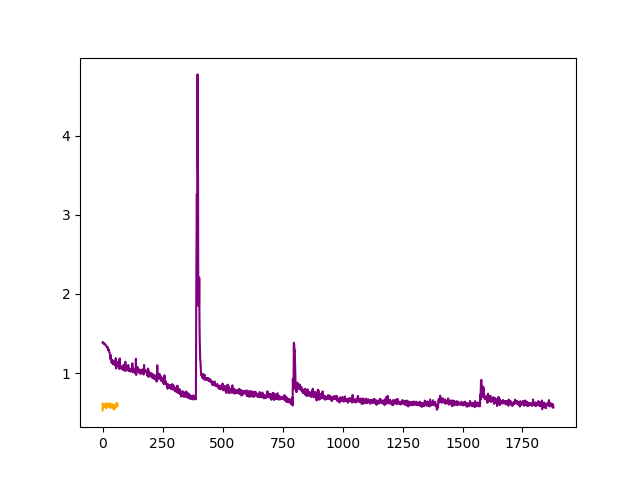

In [ ]:
plt.close('all')
plt.figure()
plt.plot(np.arange(len(train_loss)), train_loss, color='purple')
plt.plot(np.arange(len(val_loss)), val_loss, color='orange')
plt.show()

In [ ]:
# all_labels = all_labels.cpu().numpy()

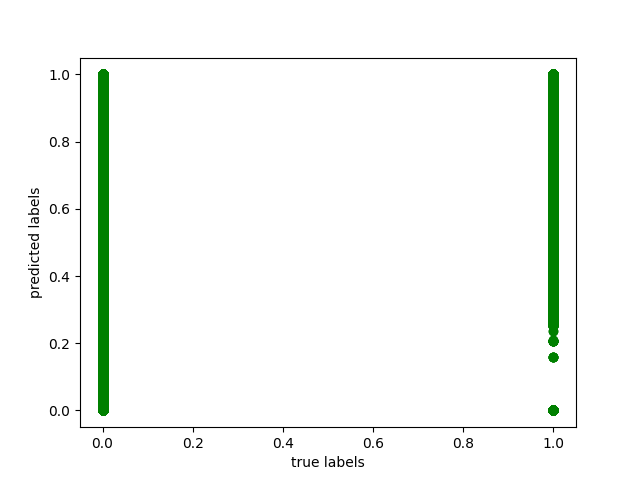

In [31]:
plt.scatter(all_labels, all_preds, color='green')
plt.xlabel('true labels')
plt.ylabel('predicted labels')
plt.show()

In [ ]:
# visualize the distribution better

In [32]:
rounded_labels_pred = np.round(all_preds)
print(rounded_labels_pred.shape)

all_0 = []
all_1 = []


for j in range(rounded_labels_pred.shape[0]):
    count_0 = 0
    count_1 = 0
    for i in rounded_labels_pred[j]:
        if int(i) == 0: count_0 += 1
        if int(i) == 1: count_1 += 1
    all_0.append(count_0)
    all_1.append(count_1)

print(all_0)
print(all_1)


(2000, 500)
[496, 496, 496, 496, 496, 489, 496, 495, 496, 496, 496, 495, 495, 493, 495, 496, 496, 496, 496, 496, 495, 495, 496, 495, 496, 495, 494, 495, 495, 497, 496, 491, 496, 496, 496, 496, 496, 496, 496, 495, 495, 496, 495, 492, 490, 495, 496, 496, 496, 496, 496, 496, 495, 495, 496, 496, 496, 496, 496, 496, 496, 496, 496, 495, 496, 495, 496, 496, 496, 492, 496, 496, 496, 495, 496, 496, 496, 495, 495, 496, 496, 496, 490, 496, 494, 496, 496, 495, 495, 496, 496, 495, 492, 496, 494, 495, 495, 496, 496, 495, 496, 496, 496, 496, 496, 496, 495, 496, 496, 496, 490, 495, 496, 496, 495, 495, 496, 495, 495, 496, 492, 496, 496, 495, 496, 495, 496, 495, 495, 496, 496, 496, 496, 495, 496, 496, 495, 495, 496, 495, 496, 495, 495, 496, 495, 496, 495, 496, 496, 496, 496, 495, 495, 496, 496, 496, 496, 496, 496, 496, 495, 490, 496, 496, 496, 496, 496, 496, 496, 496, 493, 495, 496, 496, 496, 496, 496, 496, 491, 496, 496, 495, 495, 495, 493, 496, 495, 495, 495, 496, 496, 495, 496, 496, 495, 496, 496, 49

In [ ]:
len(all_1)
print(np.mean(all_1))

13.766
